# Objetivo: Regressão no dataset “Real estate valuation” (UCI) com modelos do scikit-learn

    Reaproveitar suas funções utilitárias (aux.*) para métricas (incluindo Hit@10), correlações e análise de resíduos.

    Avaliar modelos adicionais além de Perceptron Logístico/MLP:
    SVR (linear/rbf), DecisionTreeRegressor, RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, BaggingRegressor.

    Comparar 4 tratamentos de features: sem normalização, z-score, min-max e interquartil (IQR).

    Selecionar o melhor absoluto priorizando Hit@10 (depois Hit@20, R² e, por fim, RMSE menor).

    Manter k-fold e toda a impressão/análise via aux.imprimir_metricas, aux.imprimir_correlacoes e aux.analisar_residuos.


In [1]:
import numpy as np
import pandas as pd

from ucimlrepo import fetch_ucirepo
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Modelos sklearn
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor, ExtraTreesRegressor,
    GradientBoostingRegressor, BaggingRegressor
)

# Pacote do trabalho (funções utilitárias)
from trabalho_ic_aplicada.models import aux

np.random.seed(42)


2025-08-19 20:30:02.618 | INFO     | trabalho_ic_aplicada.config:<module>:11 - PROJ_ROOT path is: /home/apo-note/Documents/Github/Trabalhos_IC_Aplicada


### [01] Carregamento do dataset e definição dos folds

    Mesmo dataset e estrutura de folds do seu código, para comparabilidade.

    Não normalizamos o alvo y (a normalização aqui será apenas nas features).

In [2]:
real_estate_valuation = fetch_ucirepo(id=477)

# Nomes das variáveis (apenas informativo; a 1ª é data)
features = real_estate_valuation.variables.iloc[1:, 0].values

# Matriz X e vetor y
X = real_estate_valuation.data.features.to_numpy()
y = real_estate_valuation.data.targets.to_numpy().ravel()

# Remove a 1ª coluna (data de transação)
X = X[:, 1:]

# Índices dos folds (mesmo esquema do seu projeto)
k_fold = aux.validacao_cruzada_kfold(X, y, k=10)
len(k_fold)


10

### [02] Escalonadores de features e critério de seleção

    Escalonadores:

        "none" → sem normalização (pass-through)

        "zscore" → StandardScaler

        "minmax" → MinMaxScaler

        "iqr" → RobustScaler (faixa interquartil)

    Critério do “melhor absoluto”: ordenar por Hit@10 (desc), depois Hit@20 (desc), R² (desc) e RMSE (asc).

In [3]:

def make_scaler(kind: str):
    if kind == "none":
        return "passthrough"
    if kind == "zscore":
        return StandardScaler()
    if kind == "minmax":
        return MinMaxScaler()
    if kind == "iqr":
        # IQR ~ robust scaler
        return RobustScaler(with_centering=True, with_scaling=True, quantile_range=(25.0, 75.0))
    raise ValueError(f"Escalonador desconhecido: {kind}")


def rank_dataframe(df):
    # Ordena por: Hit@10 desc, Hit@20 desc, R2 desc, RMSE asc
    return df.sort_values(
        by=["Hit@10_mean", "Hit@20_mean", "R2_mean", "RMSE_mean"],
        ascending=[False, False, False, True]
    ).reset_index(drop=True)


### [03] Avaliação k-fold por modelo × escalonador

    Para cada combinação, treinamos e medimos EQM, RMSE, R², Hit@20 e Hit@10 com seu aux.calcular_metricas.

    Também guardamos correlações e y_true/y_pred (treino/teste) para a análise de resíduos.

    Observação: modelos do sklearn não expõem histórico de loss por época; por isso, não há loss_history aqui.

In [4]:

def evaluate_model_cv(model_name, model, scaler_kind, X, y, k_fold):
    eqms, reqms, r2s, hit20s, hit10s = [], [], [], [], []
    corrs_train, corrs_test = [], []
    y_tr_all, y_tr_pred_all = [], []
    y_te_all, y_te_pred_all = [], []

    pipe = Pipeline([("scaler", make_scaler(scaler_kind)), ("model", model)])

    for tr_idx, te_idx in k_fold:
        X_tr, X_te = X[tr_idx, :], X[te_idx, :]
        y_tr, y_te = y[tr_idx], y[te_idx]

        # Treino & predição
        pipe.fit(X_tr, y_tr)
        y_tr_pred = pipe.predict(X_tr)
        y_te_pred = pipe.predict(X_te)

        # Correlações
        corrs_train.append(np.corrcoef(y_tr, y_tr_pred)[0, 1])
        corrs_test.append(np.corrcoef(y_te, y_te_pred)[0, 1])

        # Métricas (teste) – usa sua função
        eqm, reqm, r2, hit20, hit10, _ = aux.calcular_metricas(y_te, y_te_pred, aux)
        eqms.append(eqm);
        reqms.append(reqm);
        r2s.append(r2)
        hit20s.append(hit20);
        hit10s.append(hit10)

        # Acumula para análises globais
        y_tr_all.extend(y_tr);
        y_tr_pred_all.extend(y_tr_pred)
        y_te_all.extend(y_te);
        y_te_pred_all.extend(y_te_pred)

    summary = {
        "model": model_name,
        "scaler": scaler_kind,
        "R2_mean": float(np.mean(r2s)),
        "RMSE_mean": float(np.mean(reqms)),
        "Hit@20_mean": float(np.mean(hit20s)),
        "Hit@10_mean": float(np.mean(hit10s)),
    }

    return {
        "summary": summary,
        "fold_metrics": (eqms, reqms, r2s, hit20s, hit10s),
        "corrs": (corrs_train, corrs_test),
        "y_all": (
            np.array(y_tr_all), np.array(y_tr_pred_all),
            np.array(y_te_all), np.array(y_te_pred_all)
        ),
        # Mantemos o pipeline treinado do último fold apenas para referência
        "last_pipeline": pipe
    }


### [04] Conjunto de modelos avaliados (sklearn)

    SVR (linear e RBF)

    Decision Tree

    Random Forest

    Extra Trees

    Gradient Boosting

    Bagging (base: árvore)

    Nota sobre LSSVR: não há implementação nativa no scikit-learn. Se quiser, podemos incluir uma versão customizada depois.

In [5]:
models = {
    "SVR(linear)": SVR(kernel="linear", C=1.0, epsilon=0.1),
    "SVR(rbf)": SVR(kernel="rbf", C=10.0, gamma="scale", epsilon=0.1),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
}

scalers = ["zscore", "minmax", "iqr"]


### [05] Execução: resultados por modelo e ranking global

    Para cada modelo, comparamos os 4 escalonadores e imprimimos as métricas do melhor caso (usando seu aux.imprimir_metricas e aux.imprimir_correlacoes).

    Em seguida, criamos um ranking global (todas as combinações) priorizando Hit@10.

In [6]:
all_results = []
best_per_model = {}
rows_for_df = []

for name, model in models.items():
    model_results = []
    for sc in scalers:
        res = evaluate_model_cv(name, clone(model), sc, X, y, k_fold)
        model_results.append(res)
        all_results.append(res)
        rows_for_df.append(res["summary"])

    # Ranking interno do modelo
    df_model = rank_dataframe(pd.DataFrame([r["summary"] for r in model_results]))
    best_row = df_model.iloc[0].to_dict()
    best_obj = next(r for r in model_results
                    if r["summary"]["model"] == best_row["model"]
                    and r["summary"]["scaler"] == best_row["scaler"])

    best_per_model[name] = {
        "best_summary": best_row,
        "ranking": df_model,
        "result_obj": best_obj
    }

    # ---- Impressões do melhor caso por modelo
    print("=" * 90)
    print(f"Melhor para {name} | Escalonador: {best_row['scaler']}")
    print(f"Hit@10={best_row['Hit@10_mean']:.4f} | Hit@20={best_row['Hit@20_mean']:.4f} | "
          f"R²={best_row['R2_mean']:.4f} | RMSE={best_row['RMSE_mean']:.4f}")

    # Listas por fold para suas funções
    eqms, reqms, r2s, hit20s, hit10s = best_obj["fold_metrics"]
    corr_tr, corr_te = best_obj["corrs"]

    aux.imprimir_metricas(eqms, reqms, r2s, hit20s, hit10s)
    aux.imprimir_correlacoes(corr_tr, corr_te, r2s)

# ---- Ranking global (todas as combinações)
df_all = pd.DataFrame(rows_for_df)
df_global = rank_dataframe(df_all)
print("\n" + "#" * 90)
print("TOP 10 combinações (global) — critério: Hit@10, Hit@20, R², RMSE")
print(df_global.head(10).to_string(index=False))


Melhor para SVR(linear) | Escalonador: iqr
Hit@10=0.4134 | Hit@20=0.7053 | R²=0.5624 | RMSE=8.8303
Erro Quadrático Médio (EQM): 81.9912 ± 39.8832
Raiz do Erro Quadrático Médio (REQM): 8.8303 ± 2.0044
Hit rate 20%: 0.7053 ± 0.0727
Hit rate 10%: 0.4134 ± 0.0936

--- Coeficientes de Correlação (Real vs. Previsto) ---
Correlação Média (Treino): 0.7556 ± 0.0090
Correlação Média (Teste): 0.7628 ± 0.0799
Coeficiente de Determinação (R²): 0.5624 ± 0.1157
Melhor para SVR(rbf) | Escalonador: zscore
Hit@10=0.5274 | Hit@20=0.8133 | R²=0.6735 | RMSE=7.6062
Erro Quadrático Médio (EQM): 61.9936 ± 36.4178
Raiz do Erro Quadrático Médio (REQM): 7.6062 ± 2.0347
Hit rate 20%: 0.8133 ± 0.0630
Hit rate 10%: 0.5274 ± 0.1008

--- Coeficientes de Correlação (Real vs. Previsto) ---
Correlação Média (Treino): 0.8429 ± 0.0082
Correlação Média (Teste): 0.8268 ± 0.0679
Coeficiente de Determinação (R²): 0.6735 ± 0.1089
Melhor para DecisionTree | Escalonador: minmax
Hit@10=0.4440 | Hit@20=0.7412 | R²=0.4022 | RMSE=9.

### [06] Análise de resíduos do melhor absoluto

    Escolhemos a melhor combinação do ranking global e rodamos sua análise de resíduos com seus utilitários.

    Observação: para estes modelos sklearn não há loss por época, então não chamamos aux.plot_folds_loss aqui.


--- Análise de Gaussianidade dos Resíduos ---
Shapiro-Wilk (Treino): Estatística=0.7779, p-valor=0.0000
Shapiro-Wilk (Teste): Estatística=0.8189, p-valor=0.0000
Resíduos de treino NÃO seguem distribuição normal.


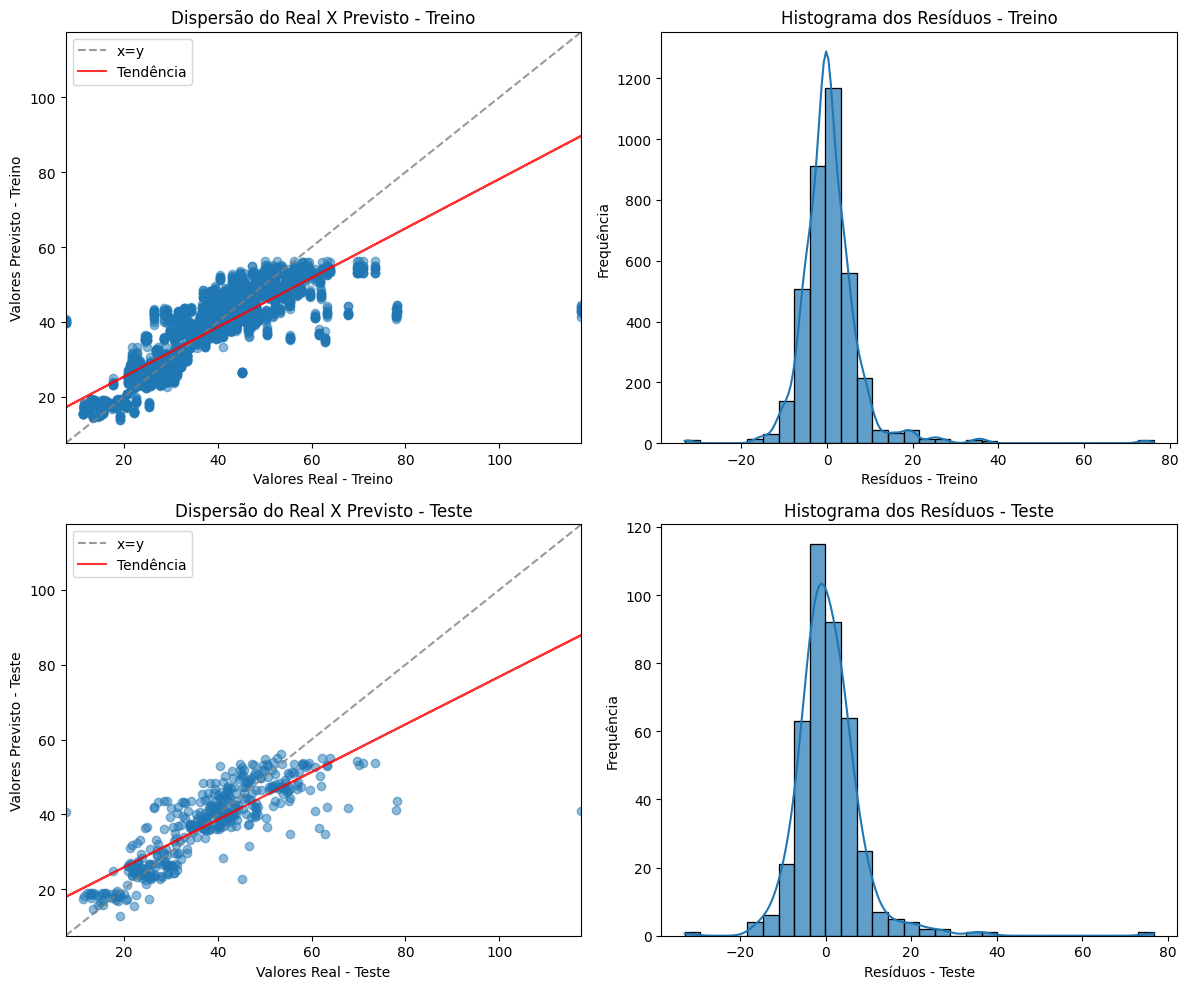

Avg. house price: 37.3042 ± 10.6281
RSME/Avg. house price: 0.1389 ± 0.1580

MELHOR GLOBAL (prioridade: Hit@10)
Modelo: SVR(rbf) | Escalonador: zscore
Hit@10=0.5274 | Hit@20=0.8133 | R²=0.6735 | RMSE=7.6062


In [7]:
best_global = df_global.iloc[0].to_dict()
best_global_obj = next(r for r in all_results
                       if r["summary"]["model"] == best_global["model"]
                       and r["summary"]["scaler"] == best_global["scaler"])

y_tr, y_tr_pred, y_te, y_te_pred = best_global_obj["y_all"]

titulo = f"Melhor global: {best_global['model']} | scaler={best_global['scaler']}"
aux.analisar_residuos(y_tr, y_tr_pred, y_te, y_te_pred, aux, titulo=titulo)


aux.calcular_metricas_normalizadas(y_te_pred, y_te)

print("\n" + "=" * 90)
print("MELHOR GLOBAL (prioridade: Hit@10)")
print(f"Modelo: {best_global['model']} | Escalonador: {best_global['scaler']}")
print(f"Hit@10={best_global['Hit@10_mean']:.4f} | Hit@20={best_global['Hit@20_mean']:.4f} | "
      f"R²={best_global['R2_mean']:.4f} | RMSE={best_global['RMSE_mean']:.4f}")


MELHOR POR MODELO (prioridade: Hit@10 > Hit@20 > R² > RMSE)

--- Análise de Gaussianidade dos Resíduos ---
Shapiro-Wilk (Treino): Estatística=0.7779, p-valor=0.0000
Shapiro-Wilk (Teste): Estatística=0.8189, p-valor=0.0000
Resíduos de treino NÃO seguem distribuição normal.


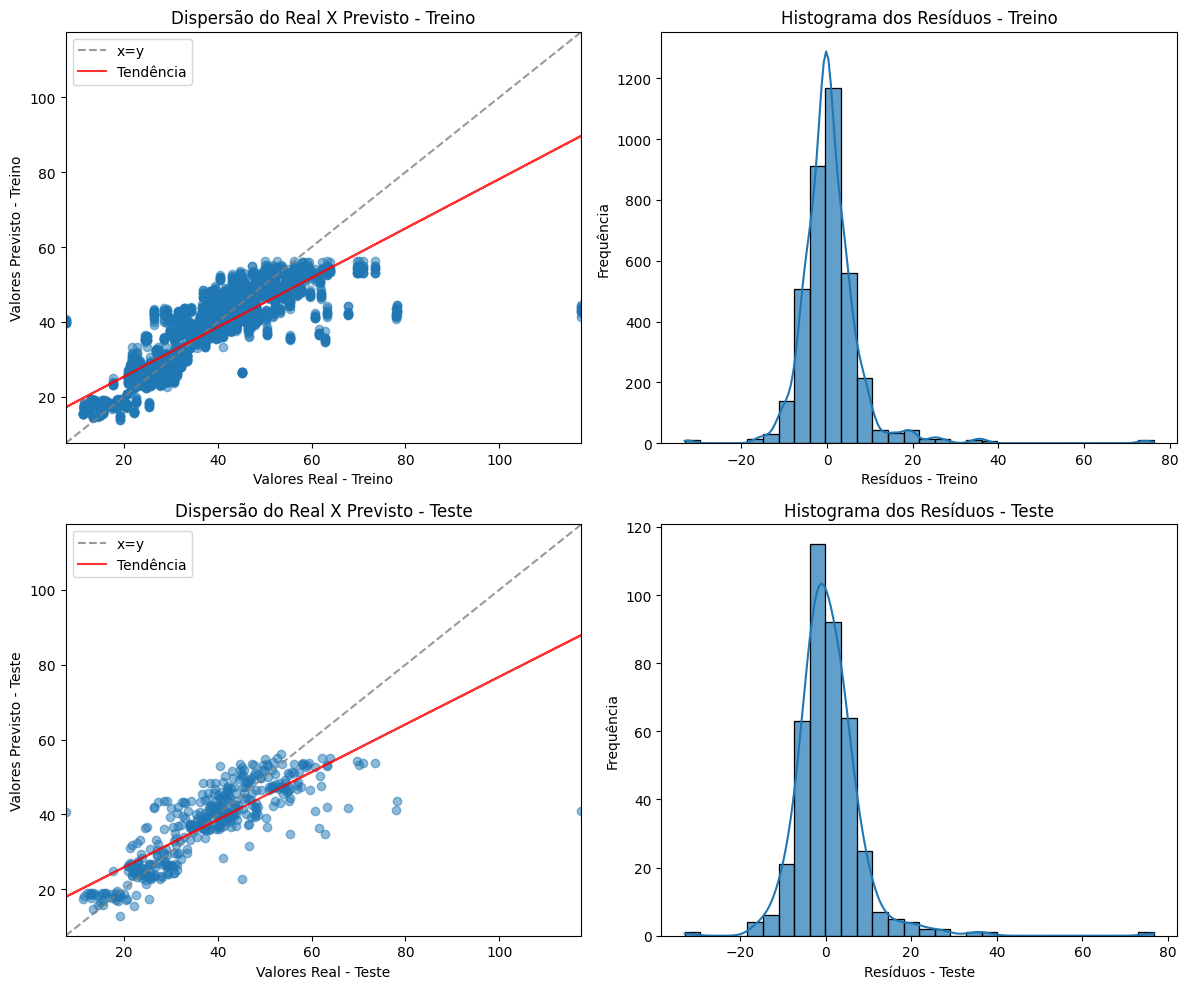

Avg. house price: 37.3042 ± 10.6281
RSME/Avg. house price: 0.1389 ± 0.1580

------------------------------------------------------------------------------------------
Modelo: SVR(rbf) | Escalonador: zscore
CV (médias): Hit@10=0.5274 | Hit@20=0.8133 | R²=0.6735 | RMSE=7.6062
Teste (deste melhor caso): R²=0.6591 | RMSE=7.9342

--- Análise de Gaussianidade dos Resíduos ---
Shapiro-Wilk (Treino): Estatística=0.8456, p-valor=0.0000
Shapiro-Wilk (Teste): Estatística=0.8260, p-valor=0.0000
Resíduos de treino NÃO seguem distribuição normal.


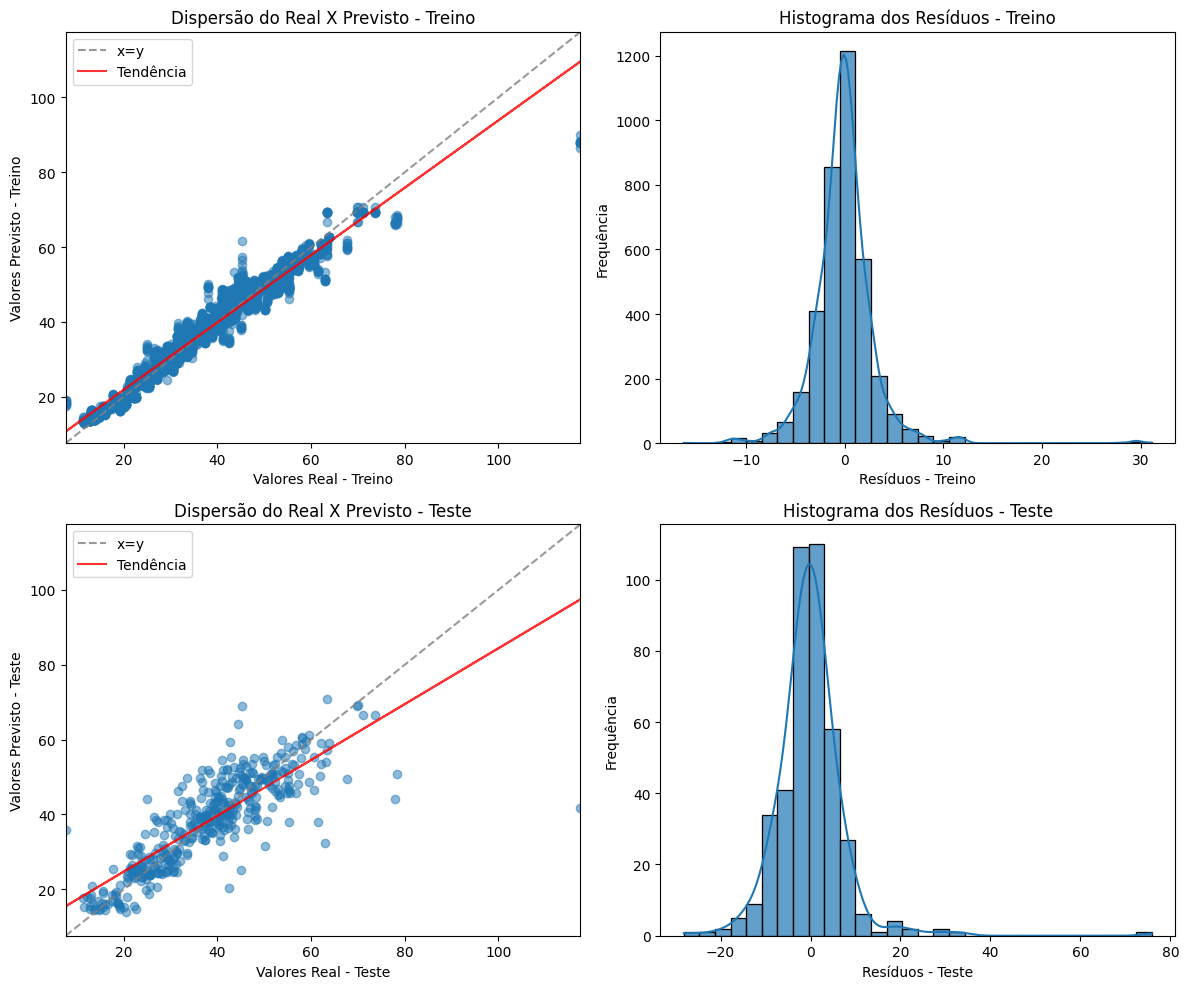

Avg. house price: 38.1375 ± 12.2557
RSME/Avg. house price: 0.1340 ± 0.1568

------------------------------------------------------------------------------------------
Modelo: RandomForest | Escalonador: minmax
CV (médias): Hit@10=0.5259 | Hit@20=0.7922 | R²=0.6815 | RMSE=7.4062
Teste (deste melhor caso): R²=0.6784 | RMSE=7.7064

--- Análise de Gaussianidade dos Resíduos ---
Shapiro-Wilk (Treino): Estatística=0.9606, p-valor=0.0000
Shapiro-Wilk (Teste): Estatística=0.8145, p-valor=0.0000
Resíduos de treino NÃO seguem distribuição normal.


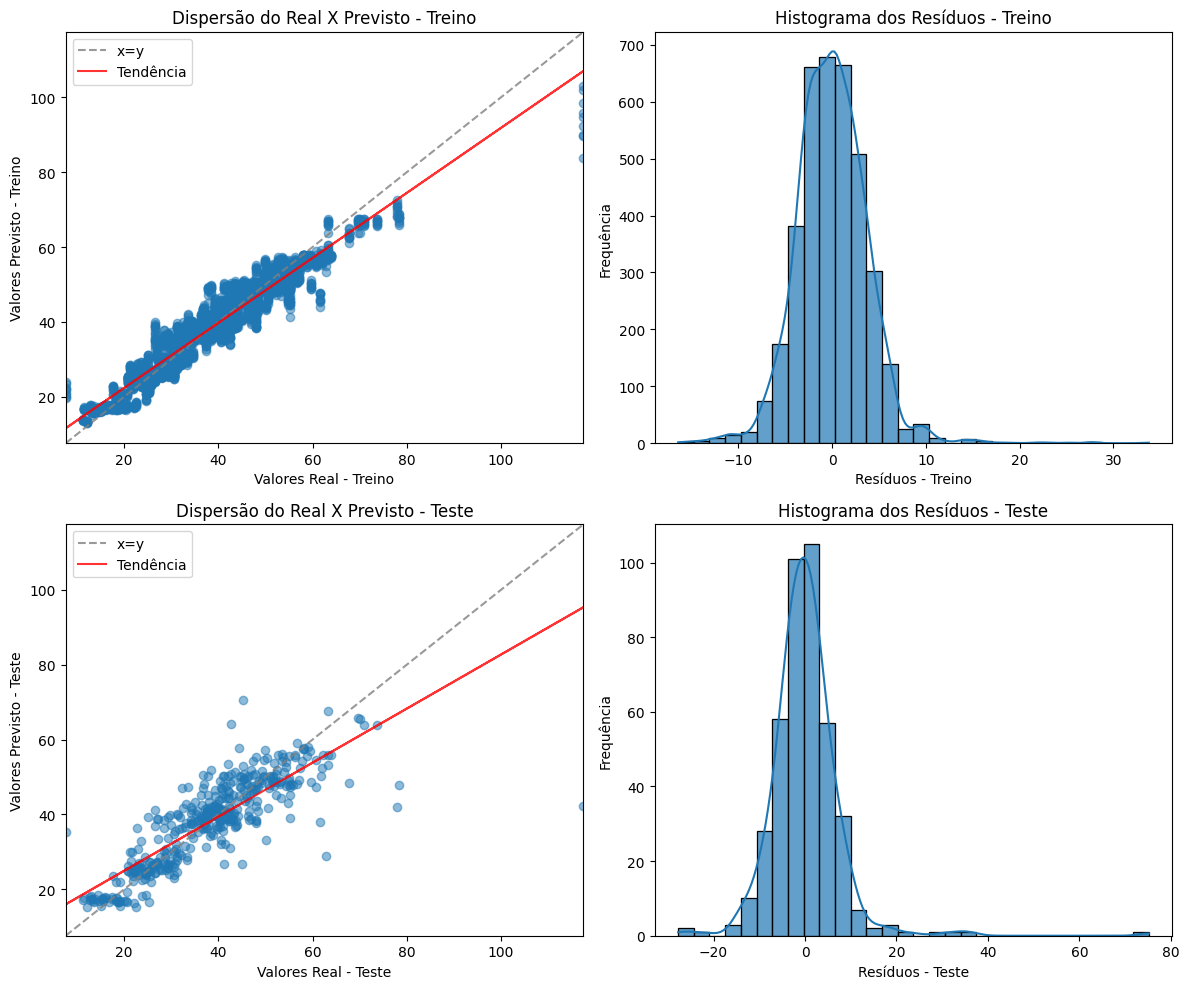

Avg. house price: 37.9251 ± 11.8078
RSME/Avg. house price: 0.1322 ± 0.1508

------------------------------------------------------------------------------------------
Modelo: GradientBoosting | Escalonador: zscore
CV (médias): Hit@10=0.5150 | Hit@20=0.8042 | R²=0.7017 | RMSE=7.2242
Teste (deste melhor caso): R²=0.6894 | RMSE=7.5742

--- Análise de Gaussianidade dos Resíduos ---
Shapiro-Wilk (Treino): Estatística=0.4810, p-valor=0.0000
Shapiro-Wilk (Teste): Estatística=0.8339, p-valor=0.0000
Resíduos de treino NÃO seguem distribuição normal.


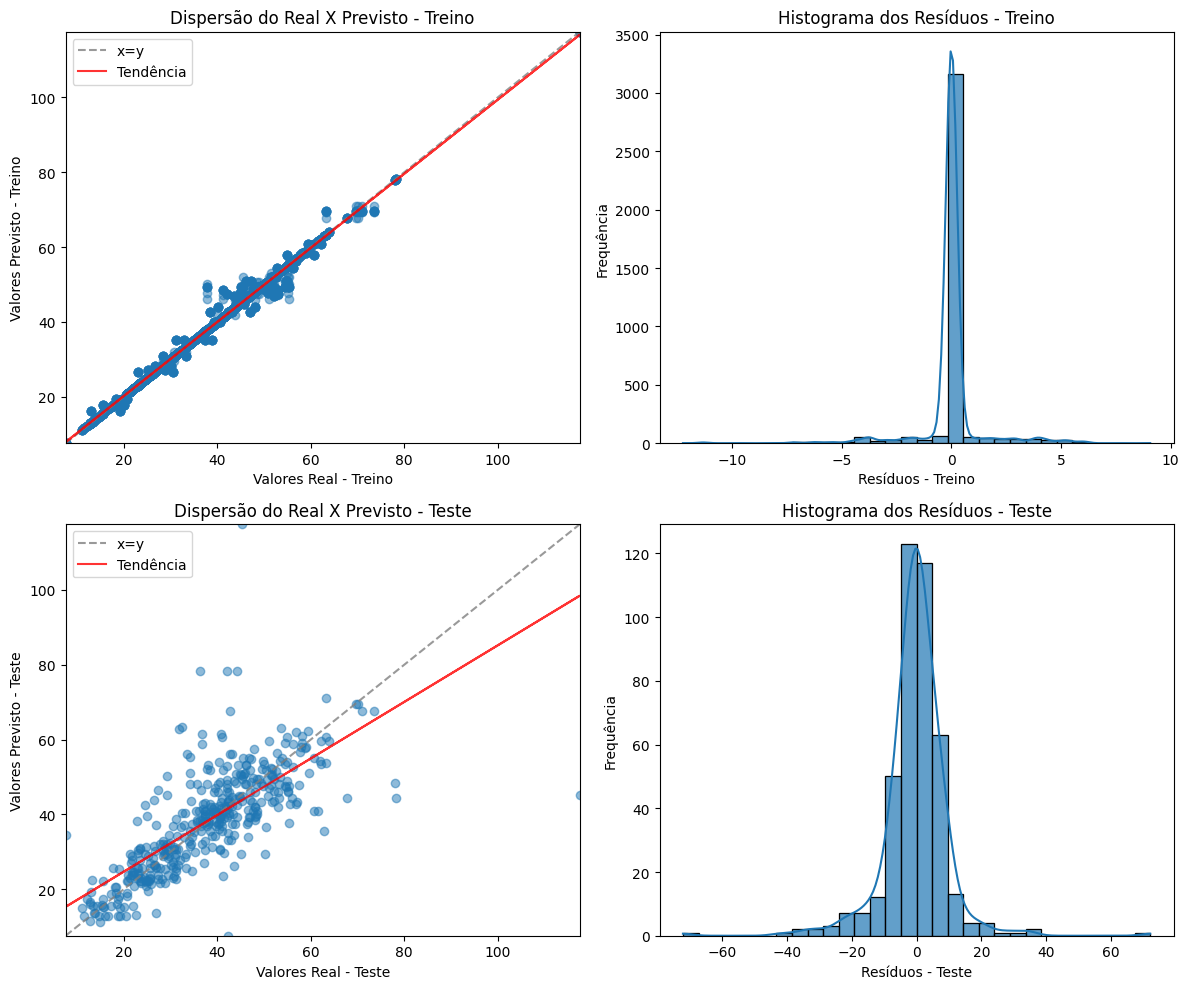

Avg. house price: 38.2927 ± 13.9486
RSME/Avg. house price: 0.1702 ± 0.2741

------------------------------------------------------------------------------------------
Modelo: DecisionTree | Escalonador: minmax
CV (médias): Hit@10=0.4440 | Hit@20=0.7412 | R²=0.4022 | RMSE=9.6045
Teste (deste melhor caso): R²=0.4582 | RMSE=10.0034

--- Análise de Gaussianidade dos Resíduos ---
Shapiro-Wilk (Treino): Estatística=0.8653, p-valor=0.0000
Shapiro-Wilk (Teste): Estatística=0.8705, p-valor=0.0000
Resíduos de treino NÃO seguem distribuição normal.


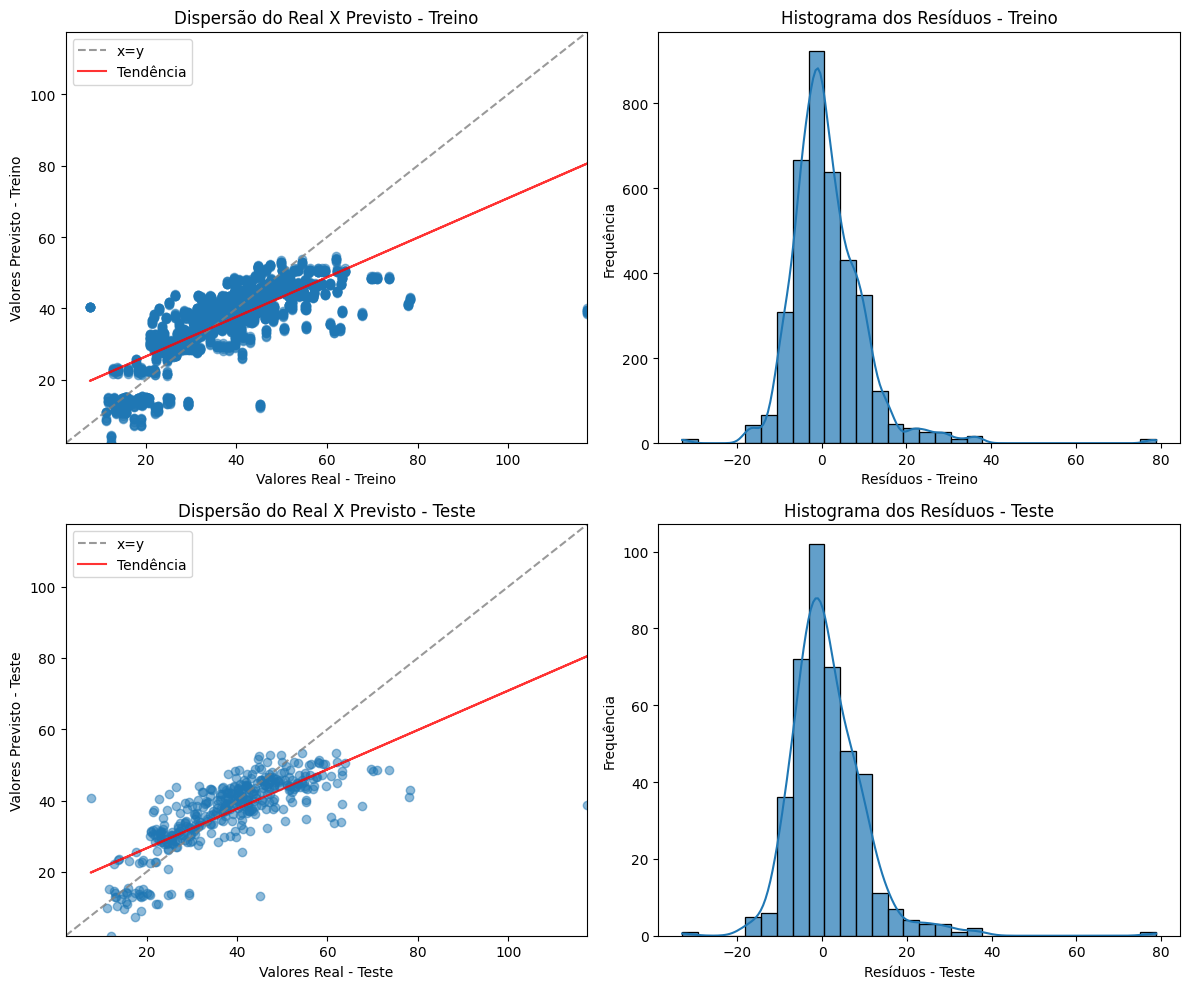

Avg. house price: 36.5642 ± 10.0214
RSME/Avg. house price: 0.2013 ± 0.3341

------------------------------------------------------------------------------------------
Modelo: SVR(linear) | Escalonador: iqr
CV (médias): Hit@10=0.4134 | Hit@20=0.7053 | R²=0.5624 | RMSE=8.8303
Teste (deste melhor caso): R²=0.5506 | RMSE=9.1101

FIM — melhor por modelo


In [9]:
### [XX] Melhor caso por modelo: análise de resíduos e métricas
#
# Para cada modelo, seleciona-se a melhor combinação (scaler) conforme a prioridade:
# Hit@10 desc, depois Hit@20 desc, depois R² desc, e por fim RMSE asc.
# Em seguida, realiza-se a análise de resíduos e impressão de métricas.

import numpy as np

# Garante que os nomes das colunas estão presentes
required_cols = ["model", "scaler", "Hit@10_mean", "Hit@20_mean", "R2_mean", "RMSE_mean"]
missing_cols = [c for c in required_cols if c not in df_global.columns]
if missing_cols:
    raise ValueError(f"Colunas ausentes em df_global: {missing_cols}")

# Seleciona o melhor por modelo
model_names = df_global["model"].unique().tolist()
print("=" * 90)
print("MELHOR POR MODELO (prioridade: Hit@10 > Hit@20 > R² > RMSE)")
print("=" * 90)

for mdl in model_names:
    dfm = df_global[df_global["model"] == mdl].copy()
    if dfm.empty:
        continue

    # Ordenação pela prioridade definida
    dfm = dfm.sort_values(
        by=["Hit@10_mean", "Hit@20_mean", "R2_mean", "RMSE_mean"],
        ascending=[False, False, False, True],
        na_position="last"
    )

    best_row = dfm.iloc[0].to_dict()

    # Recupera o objeto de resultados correspondente (mesmo modelo e scaler)
    best_obj = next(
        r for r in all_results
        if r["summary"]["model"] == best_row["model"] and r["summary"]["scaler"] == best_row["scaler"]
    )

    # y de treino/teste e suas predições
    y_tr, y_tr_pred, y_te, y_te_pred = best_obj["y_all"]

    titulo = f"Melhor por modelo: {best_row['model']} | scaler={best_row['scaler']}"
    aux.analisar_residuos(y_tr, y_tr_pred, y_te, y_te_pred, aux, titulo=titulo)

    # Métricas normalizadas (conforme seu auxiliar)
    aux.calcular_metricas_normalizadas(y_te_pred, y_te)

    # RMSE e R² no conjunto de teste (deste melhor caso)
    resid = y_te - y_te_pred
    rmse_te = float(np.sqrt(np.mean(resid ** 2)))
    ss_res = float(np.sum(resid ** 2))
    ss_tot = float(np.sum((y_te - np.mean(y_te)) ** 2))
    r2_te = float(1 - ss_res / ss_tot) if ss_tot > 0 else np.nan

    print("\n" + "-" * 90)
    print(f"Modelo: {best_row['model']} | Escalonador: {best_row['scaler']}")
    print(
        f"CV (médias): Hit@10={best_row['Hit@10_mean']:.4f} | "
        f"Hit@20={best_row['Hit@20_mean']:.4f} | R²={best_row['R2_mean']:.4f} | "
        f"RMSE={best_row['RMSE_mean']:.4f}"
    )
    print(f"Teste (deste melhor caso): R²={r2_te:.4f} | RMSE={rmse_te:.4f}")

print("\n" + "=" * 90)
print("FIM — melhor por modelo")

Melhor para SVR(linear) | Escalonador: iqr
CV (médias por fold): Hit@10=0.4134 | Hit@20=0.7053 | R²=0.5624 | RMSE=8.8303
Erro Quadrático Médio (EQM): 81.9912 ± 39.8832
Raiz do Erro Quadrático Médio (REQM): 8.8303 ± 2.0044
Hit rate 20%: 0.7053 ± 0.0727
Hit rate 10%: 0.4134 ± 0.0936

--- Coeficientes de Correlação (Real vs. Previsto) ---
Correlação Média (Treino): 0.7556 ± 0.0090
Correlação Média (Teste): 0.7628 ± 0.0799
Coeficiente de Determinação (R²): 0.5624 ± 0.1157
OOF agregado (10 folds): R²=0.5506 | RMSE=9.1101 | Hit@10=0.4130 | Hit@20=0.7053
Avg. house price: 36.5642 ± 10.0214
RSME/Avg. house price: 0.2013 ± 0.3341

--- Análise de Gaussianidade dos Resíduos ---
Shapiro-Wilk (Treino): Estatística=0.8653, p-valor=0.0000
Shapiro-Wilk (Teste): Estatística=0.8705, p-valor=0.0000
Resíduos de treino NÃO seguem distribuição normal.


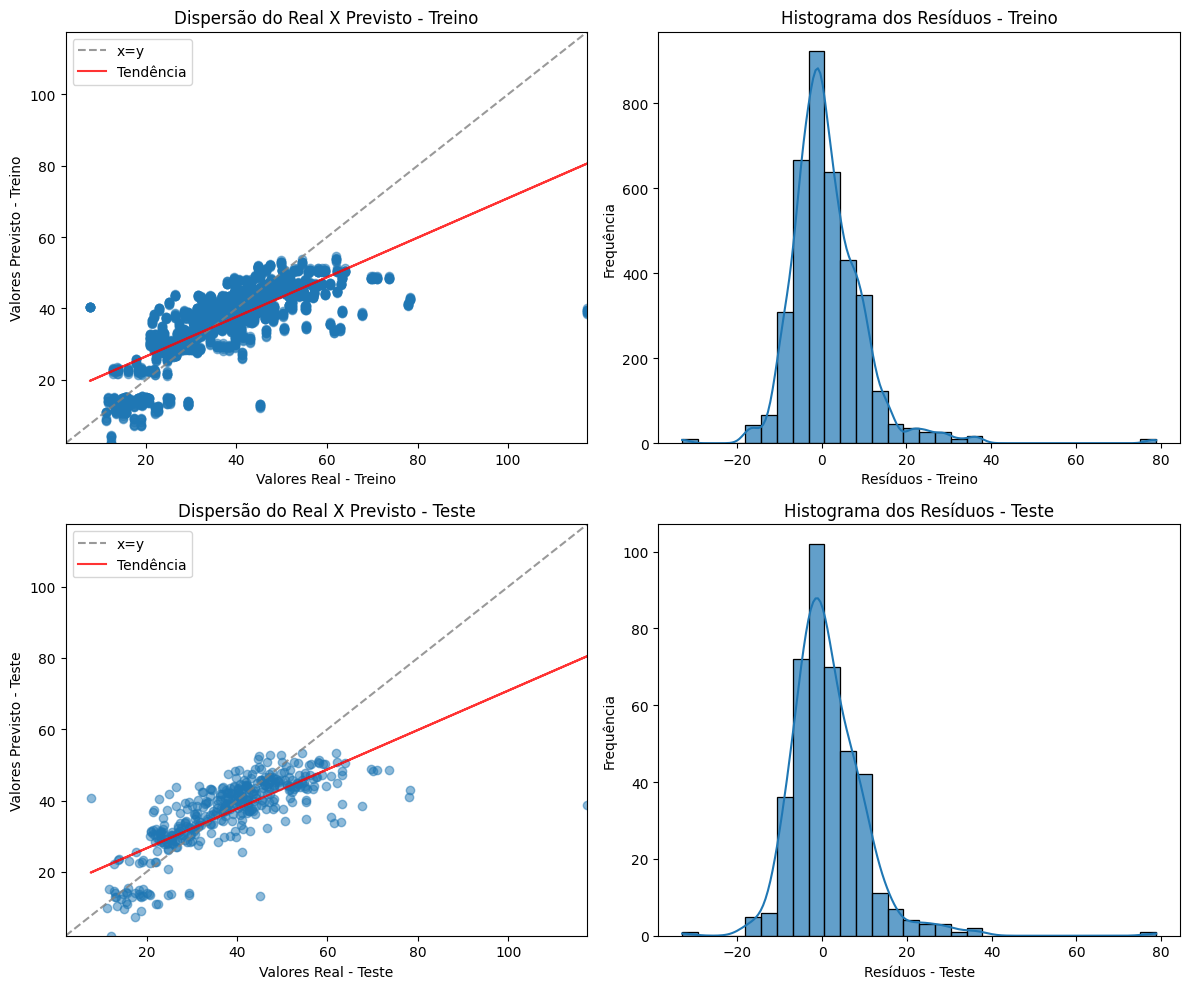

Melhor para SVR(rbf) | Escalonador: zscore
CV (médias por fold): Hit@10=0.5274 | Hit@20=0.8133 | R²=0.6735 | RMSE=7.6062
Erro Quadrático Médio (EQM): 61.9936 ± 36.4178
Raiz do Erro Quadrático Médio (REQM): 7.6062 ± 2.0347
Hit rate 20%: 0.8133 ± 0.0630
Hit rate 10%: 0.5274 ± 0.1008

--- Coeficientes de Correlação (Real vs. Previsto) ---
Correlação Média (Treino): 0.8429 ± 0.0082
Correlação Média (Teste): 0.8268 ± 0.0679
Coeficiente de Determinação (R²): 0.6735 ± 0.1089
OOF agregado (10 folds): R²=0.6591 | RMSE=7.9342 | Hit@10=0.5266 | Hit@20=0.8140
Avg. house price: 37.3042 ± 10.6281
RSME/Avg. house price: 0.1389 ± 0.1580

--- Análise de Gaussianidade dos Resíduos ---
Shapiro-Wilk (Treino): Estatística=0.7779, p-valor=0.0000
Shapiro-Wilk (Teste): Estatística=0.8189, p-valor=0.0000
Resíduos de treino NÃO seguem distribuição normal.


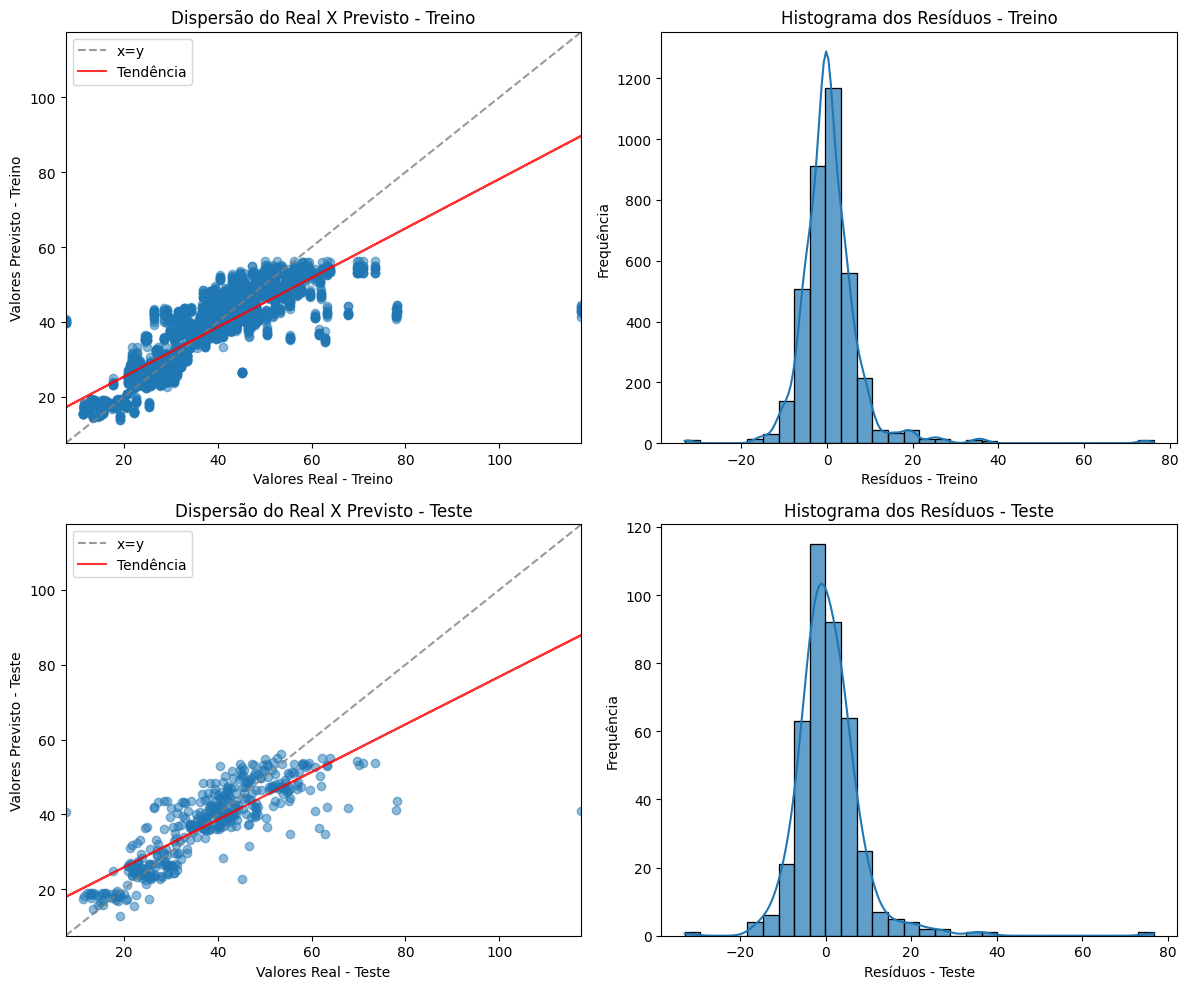

Melhor para DecisionTree | Escalonador: minmax
CV (médias por fold): Hit@10=0.4440 | Hit@20=0.7412 | R²=0.4022 | RMSE=9.6045
Erro Quadrático Médio (EQM): 99.3910 ± 57.4732
Raiz do Erro Quadrático Médio (REQM): 9.6045 ± 2.6728
Hit rate 20%: 0.7412 ± 0.0732
Hit rate 10%: 0.4440 ± 0.0844

--- Coeficientes de Correlação (Real vs. Previsto) ---
Correlação Média (Treino): 0.9950 ± 0.0005
Correlação Média (Teste): 0.7570 ± 0.1121
Coeficiente de Determinação (R²): 0.4022 ± 0.4425
OOF agregado (10 folds): R²=0.4582 | RMSE=10.0034 | Hit@10=0.4444 | Hit@20=0.7415
Avg. house price: 38.2927 ± 13.9486
RSME/Avg. house price: 0.1702 ± 0.2741

--- Análise de Gaussianidade dos Resíduos ---
Shapiro-Wilk (Treino): Estatística=0.4810, p-valor=0.0000
Shapiro-Wilk (Teste): Estatística=0.8339, p-valor=0.0000
Resíduos de treino NÃO seguem distribuição normal.


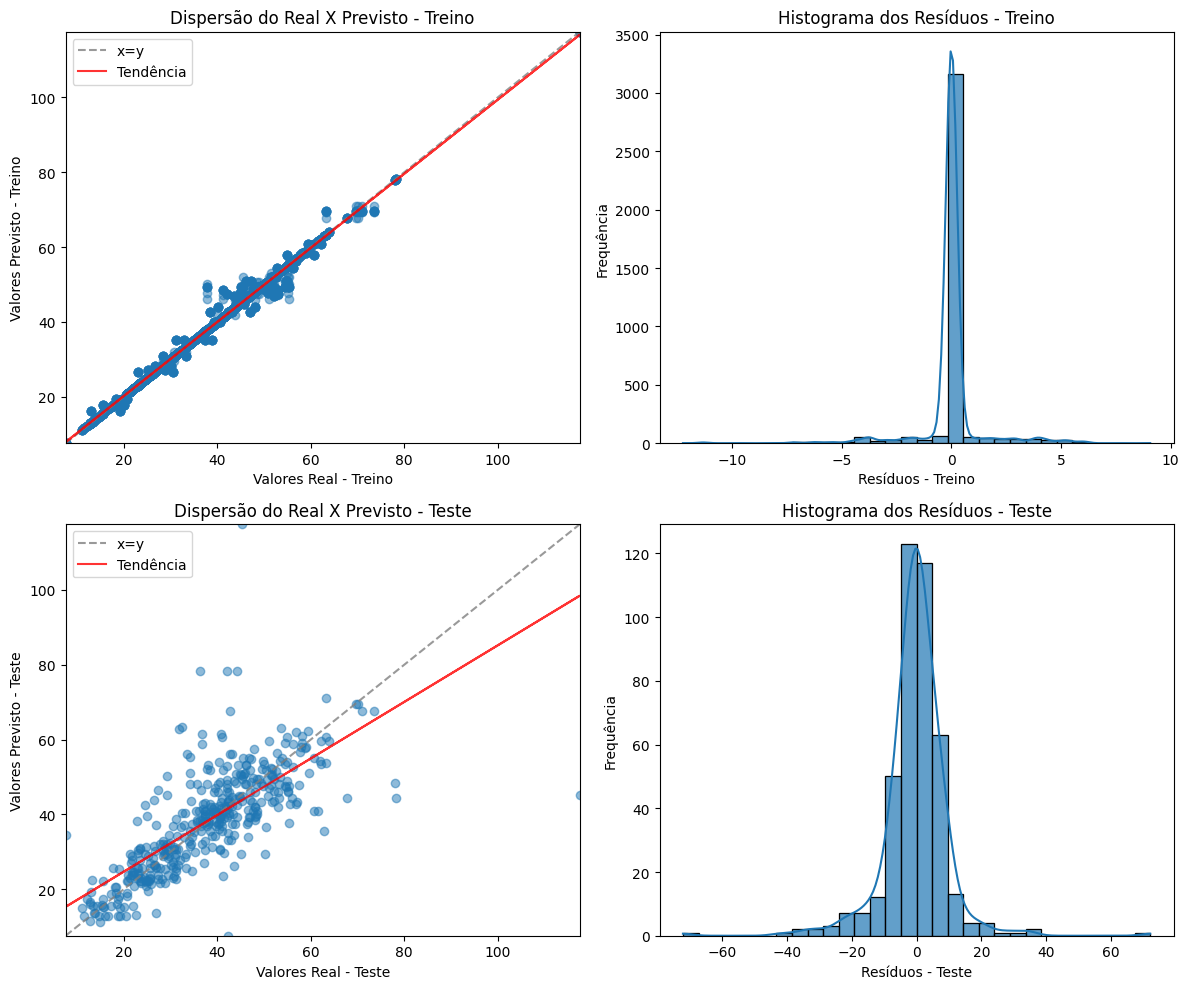

Melhor para RandomForest | Escalonador: minmax
CV (médias por fold): Hit@10=0.5259 | Hit@20=0.7922 | R²=0.6815 | RMSE=7.4062
Erro Quadrático Médio (EQM): 58.4084 ± 35.1177
Raiz do Erro Quadrático Médio (REQM): 7.4062 ± 1.8858
Hit rate 20%: 0.7922 ± 0.0465
Hit rate 10%: 0.5259 ± 0.0865

--- Coeficientes de Correlação (Real vs. Previsto) ---
Correlação Média (Treino): 0.9751 ± 0.0015
Correlação Média (Teste): 0.8362 ± 0.0688
Coeficiente de Determinação (R²): 0.6815 ± 0.1254
OOF agregado (10 folds): R²=0.6784 | RMSE=7.7064 | Hit@10=0.5266 | Hit@20=0.7923
Avg. house price: 38.1375 ± 12.2557
RSME/Avg. house price: 0.1340 ± 0.1568

--- Análise de Gaussianidade dos Resíduos ---
Shapiro-Wilk (Treino): Estatística=0.8456, p-valor=0.0000
Shapiro-Wilk (Teste): Estatística=0.8260, p-valor=0.0000
Resíduos de treino NÃO seguem distribuição normal.


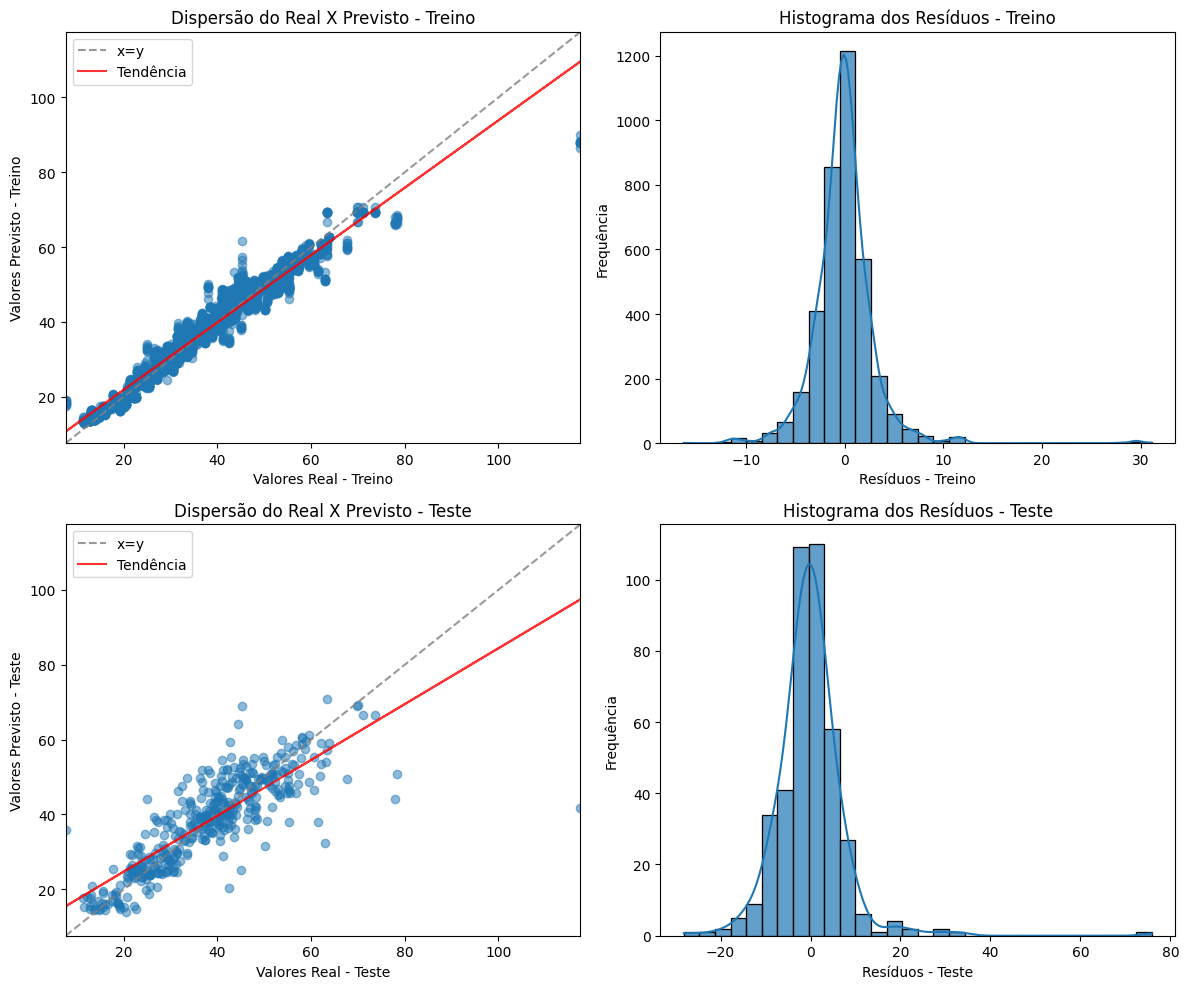

Melhor para ExtraTrees | Escalonador: zscore
CV (médias por fold): Hit@10=0.4702 | Hit@20=0.7844 | R²=0.6514 | RMSE=7.6966
Erro Quadrático Médio (EQM): 63.0884 ± 36.1930
Raiz do Erro Quadrático Médio (REQM): 7.6966 ± 1.9624
Hit rate 20%: 0.7844 ± 0.0509
Hit rate 10%: 0.4702 ± 0.0666

--- Coeficientes de Correlação (Real vs. Previsto) ---
Correlação Média (Treino): 0.9950 ± 0.0005
Correlação Média (Teste): 0.8232 ± 0.0790
Coeficiente de Determinação (R²): 0.6514 ± 0.1488
OOF agregado (10 folds): R²=0.6531 | RMSE=8.0038 | Hit@10=0.4710 | Hit@20=0.7850
Avg. house price: 37.9780 ± 12.3423
RSME/Avg. house price: 0.1386 ± 0.1527

--- Análise de Gaussianidade dos Resíduos ---
Shapiro-Wilk (Treino): Estatística=0.4838, p-valor=0.0000
Shapiro-Wilk (Teste): Estatística=0.8397, p-valor=0.0000
Resíduos de treino NÃO seguem distribuição normal.


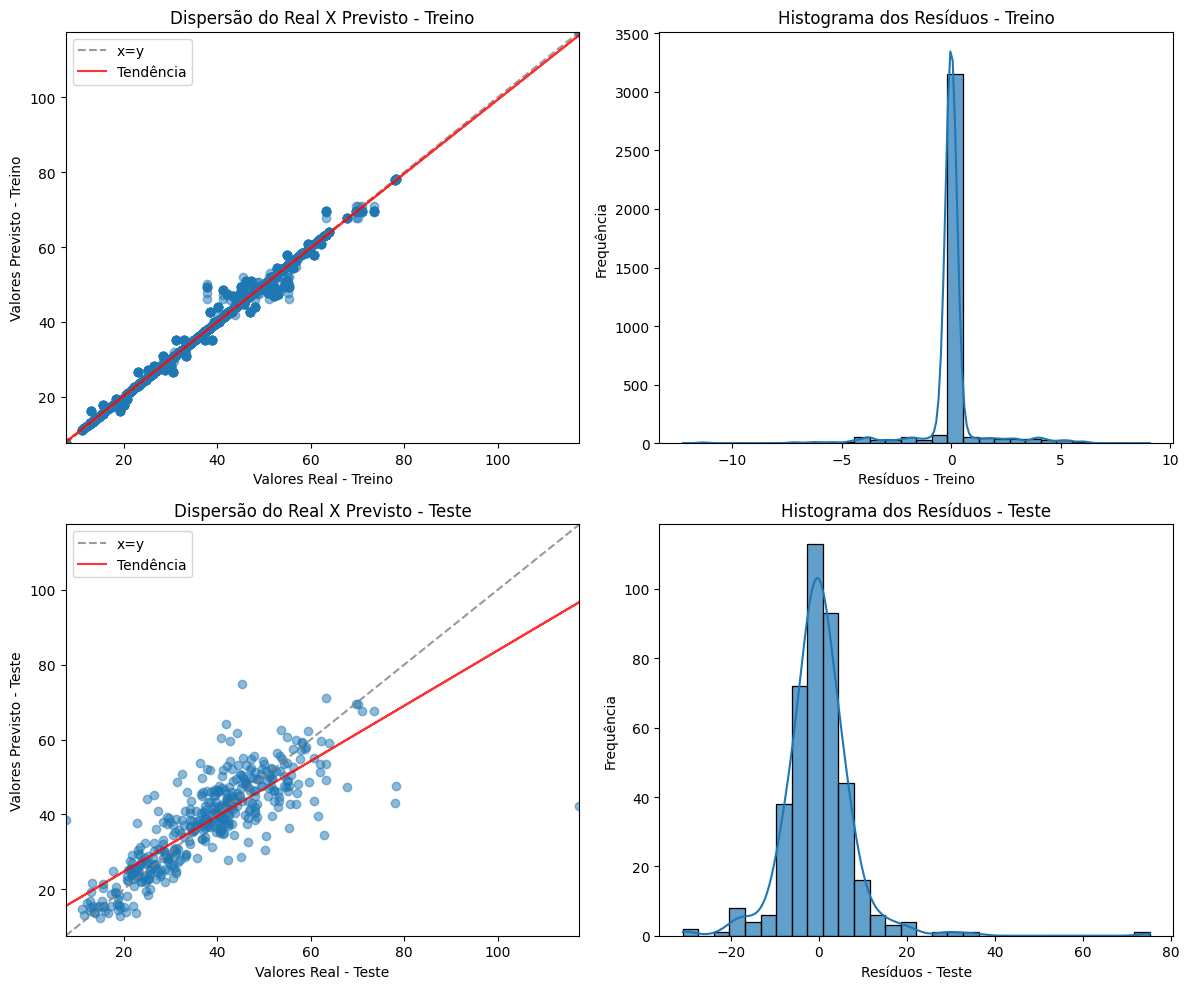

Melhor para GradientBoosting | Escalonador: none
CV (médias por fold): Hit@10=0.5150 | Hit@20=0.8066 | R²=0.7030 | RMSE=7.2067
Erro Quadrático Médio (EQM): 56.1461 ± 36.5429
Raiz do Erro Quadrático Médio (REQM): 7.2067 ± 2.0516
Hit rate 20%: 0.8066 ± 0.0249
Hit rate 10%: 0.5150 ± 0.1070

--- Coeficientes de Correlação (Real vs. Previsto) ---
Correlação Média (Treino): 0.9617 ± 0.0021
Correlação Média (Teste): 0.8453 ± 0.0664
Coeficiente de Determinação (R²): 0.7030 ± 0.1140
OOF agregado (10 folds): R²=0.6907 | RMSE=7.5584 | Hit@10=0.5145 | Hit@20=0.8068
Avg. house price: 37.9236 ± 11.8154
RSME/Avg. house price: 0.1318 ± 0.1502

--- Análise de Gaussianidade dos Resíduos ---
Shapiro-Wilk (Treino): Estatística=0.9606, p-valor=0.0000
Shapiro-Wilk (Teste): Estatística=0.8148, p-valor=0.0000
Resíduos de treino NÃO seguem distribuição normal.


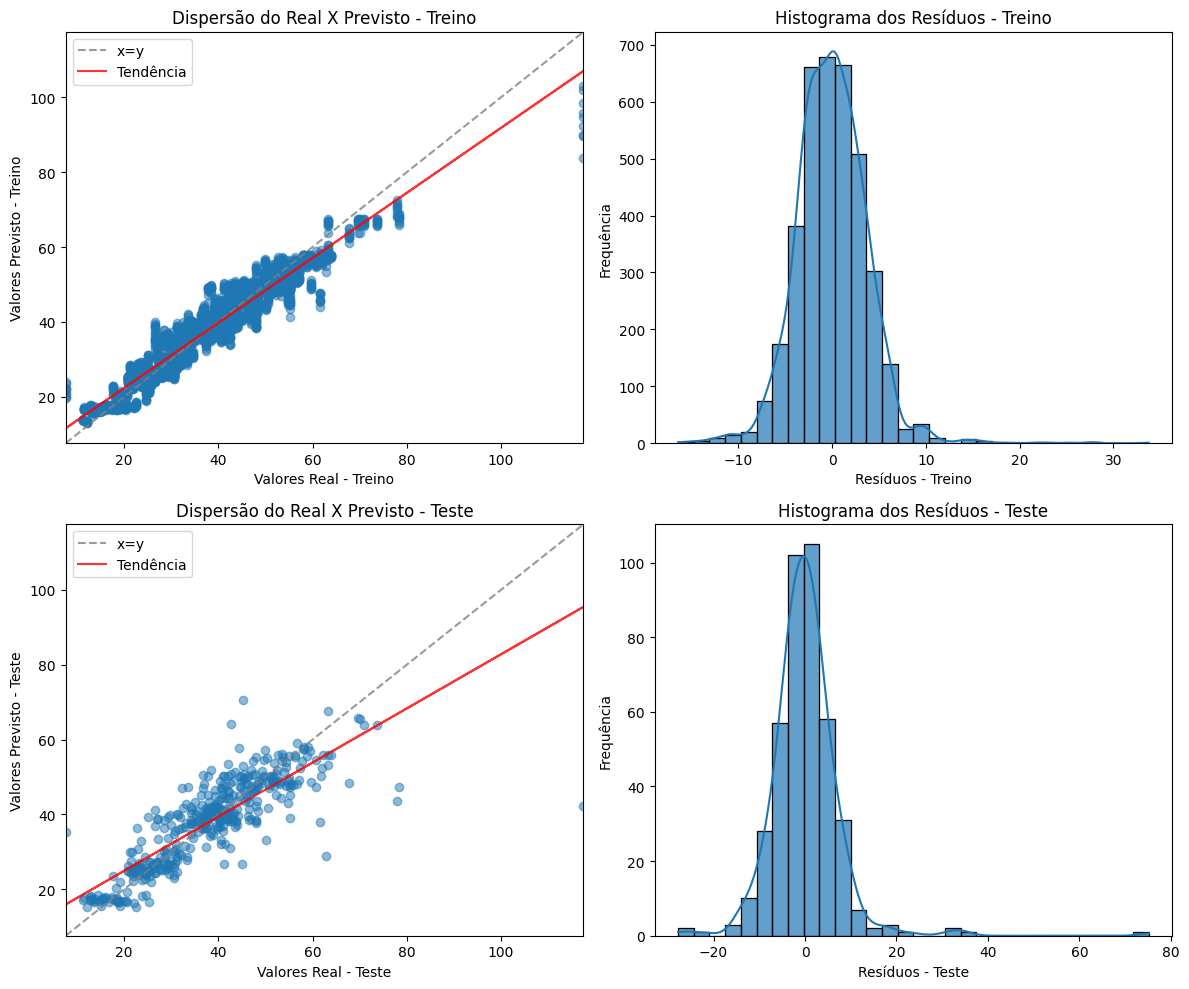

/usr/lib/python3.10/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.10/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.10/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/pyth

Melhor para Bagging(Tree) | Escalonador: minmax
CV (médias por fold): Hit@10=0.5185 | Hit@20=0.7922 | R²=0.6801 | RMSE=7.4208
Erro Quadrático Médio (EQM): 58.6105 ± 34.9378
Raiz do Erro Quadrático Médio (REQM): 7.4208 ± 1.8820
Hit rate 20%: 0.7922 ± 0.0452
Hit rate 10%: 0.5185 ± 0.0835

--- Coeficientes de Correlação (Real vs. Previsto) ---
Correlação Média (Treino): 0.9750 ± 0.0015
Correlação Média (Teste): 0.8358 ± 0.0687
Coeficiente de Determinação (R²): 0.6801 ± 0.1257
OOF agregado (10 folds): R²=0.6774 | RMSE=7.7189 | Hit@10=0.5193 | Hit@20=0.7923
Avg. house price: 38.1518 ± 12.2718
RSME/Avg. house price: 0.1339 ± 0.1559

--- Análise de Gaussianidade dos Resíduos ---
Shapiro-Wilk (Treino): Estatística=0.8454, p-valor=0.0000
Shapiro-Wilk (Teste): Estatística=0.8269, p-valor=0.0000
Resíduos de treino NÃO seguem distribuição normal.


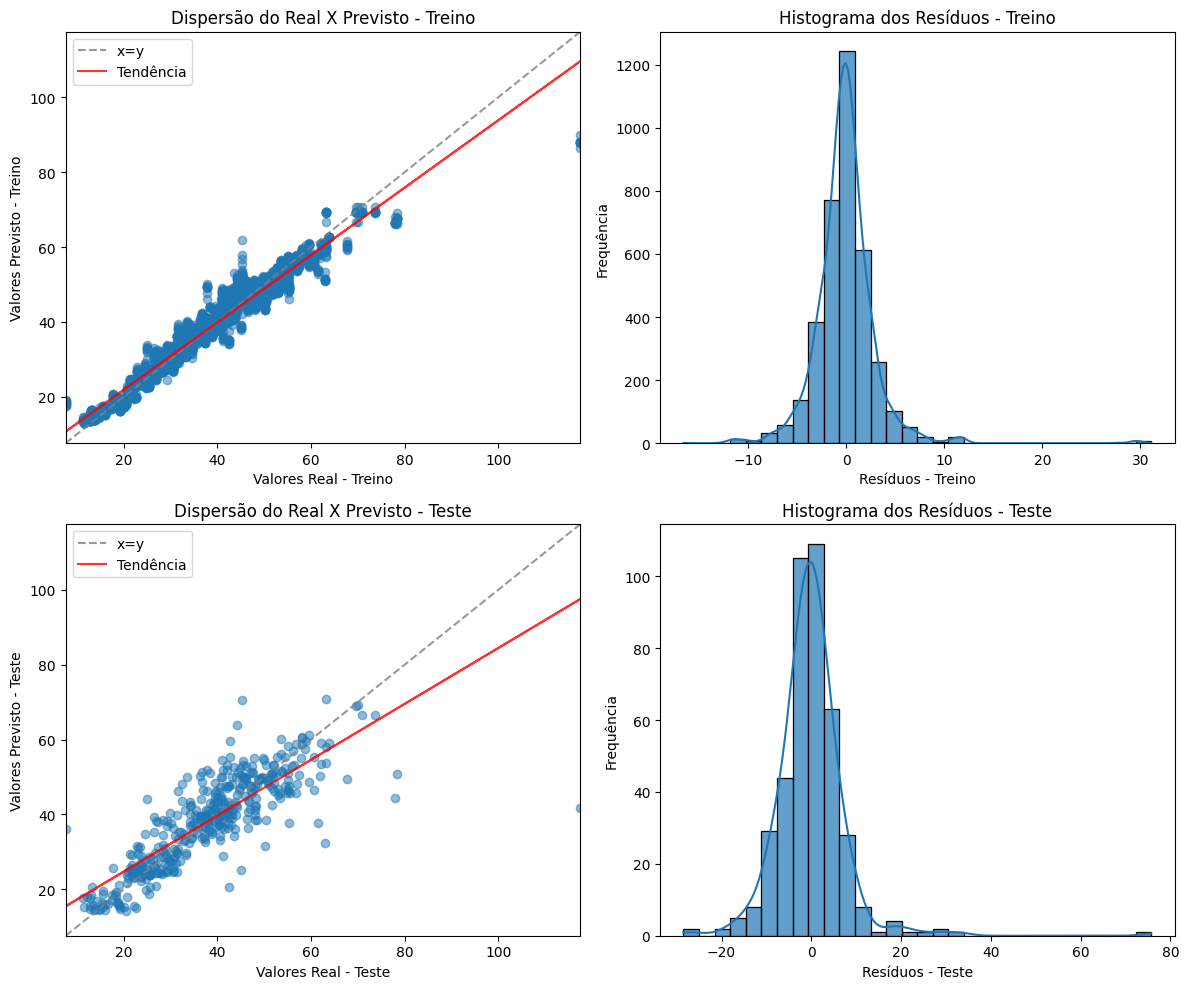


##########################################################################################
TOP 10 combinações (global) — critério: Hit@10 > Hit@20 > R² > RMSE
           model scaler  Hit@10_mean  Hit@20_mean  R2_mean  RMSE_mean
        SVR(rbf) zscore     0.527371     0.813279 0.673528   7.606154
    RandomForest minmax     0.525854     0.792195 0.681477   7.406216
    RandomForest    iqr     0.520976     0.792195 0.681501   7.408230
    RandomForest zscore     0.518753     0.789756 0.681260   7.412833
    RandomForest   none     0.518537     0.792195 0.681328   7.411018
   Bagging(Tree) minmax     0.518537     0.792195 0.680063   7.420827
   Bagging(Tree)    iqr     0.516098     0.792195 0.679891   7.425094
GradientBoosting   none     0.514959     0.806612 0.703044   7.206731
GradientBoosting zscore     0.514959     0.804173 0.701711   7.224202
GradientBoosting    iqr     0.514959     0.804173 0.701305   7.228149

MELHOR GLOBAL (prioridade: Hit@10 > Hit@20 > R² > RMSE)
Modelo: SVR(r

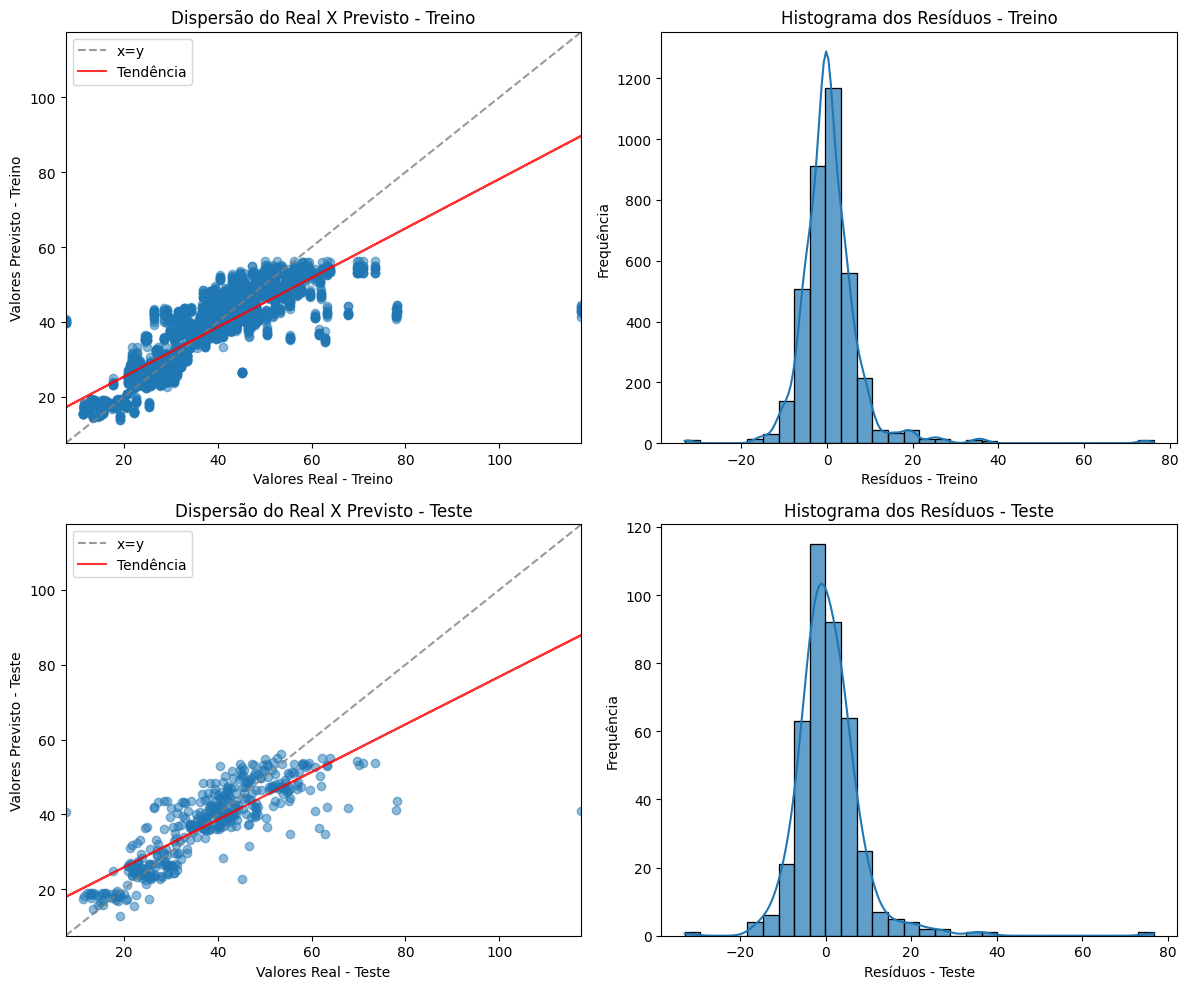


MELHOR POR MODELO (resumo final)

------------------------------------------------------------------------------------------
Modelo: SVR(rbf) | Escalonador: zscore
CV (médias por fold): Hit@10=0.5274 | Hit@20=0.8133 | R²=0.6735 | RMSE=7.6062
OOF agregado (10 folds): R²=0.6591 | RMSE=7.9342 | Hit@10=0.5266 | Hit@20=0.8140

------------------------------------------------------------------------------------------
Modelo: RandomForest | Escalonador: minmax
CV (médias por fold): Hit@10=0.5259 | Hit@20=0.7922 | R²=0.6815 | RMSE=7.4062
OOF agregado (10 folds): R²=0.6784 | RMSE=7.7064 | Hit@10=0.5266 | Hit@20=0.7923

------------------------------------------------------------------------------------------
Modelo: Bagging(Tree) | Escalonador: minmax
CV (médias por fold): Hit@10=0.5185 | Hit@20=0.7922 | R²=0.6801 | RMSE=7.4208
OOF agregado (10 folds): R²=0.6774 | RMSE=7.7189 | Hit@10=0.5193 | Hit@20=0.7923

--------------------------------------------------------------------------------------

In [10]:
# Objetivo: Regressão no dataset “Real estate valuation” (UCI) com modelos do scikit-learn
#
# - Reaproveitar aux.* para métricas (incluindo Hit@10), correlações e análise de resíduos.
# - Avaliar: SVR(linear/rbf), DecisionTree, RandomForest, ExtraTrees, GradientBoosting, Bagging(Tree).
# - Comparar 4 tratamentos de features: none, z-score, min-max, interquartil (IQR).
# - Selecionar o melhor por prioridade: Hit@10 (desc), Hit@20 (desc), R² (desc), RMSE (asc).
# - Usar K-Fold com k=10. Evitar vazamento (scaler dentro do Pipeline).
# - Imprimir:
#     (1) CV (médias por fold) com aux.imprimir_metricas
#     (2) OOF agregado (10 folds) para o melhor caso
#     (3) aux.imprimir_correlacoes
#     (4) aux.analisar_residuos e aux.calcular_metricas_normalizadas (com dados agregados)
# Obs: seguimos a assinatura dos seus auxiliares conforme o “exemplo bom”.

import numpy as np
import pandas as pd

from ucimlrepo import fetch_ucirepo
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Modelos sklearn
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor, ExtraTreesRegressor,
    GradientBoostingRegressor, BaggingRegressor
)

# Pacote do trabalho (funções utilitárias)
from trabalho_ic_aplicada.models import aux

np.random.seed(42)

### [01] Carregamento do dataset e definição dos folds

real_estate_valuation = fetch_ucirepo(id=477)

# Nomes (apenas informativo; a 1ª é data)
features = real_estate_valuation.variables.iloc[1:, 0].values

# Matriz X e vetor y
X = real_estate_valuation.data.features.to_numpy()
y = real_estate_valuation.data.targets.to_numpy().ravel()

# Remove a 1ª coluna (data de transação)
X = X[:, 1:]

# Índices dos folds (mesmo esquema do seu projeto)
k = 10
k_fold = aux.validacao_cruzada_kfold(X, y, k=k)
assert len(k_fold) == k


### [02] Escalonadores de features e utilitários

def make_scaler(kind: str):
    if kind == "none":
        return "passthrough"
    if kind == "zscore":
        return StandardScaler()
    if kind == "minmax":
        return MinMaxScaler()
    if kind == "iqr":
        # IQR ~ robust scaler (25–75)
        return RobustScaler(with_centering=True, with_scaling=True, quantile_range=(25.0, 75.0))
    raise ValueError(f"Escalonador desconhecido: {kind}")


def rank_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    # Ordena por: Hit@10 desc, Hit@20 desc, R2 desc, RMSE asc
    return df.sort_values(
        by=["Hit@10_mean", "Hit@20_mean", "R2_mean", "RMSE_mean"],
        ascending=[False, False, False, True],
        na_position="last"
    ).reset_index(drop=True)


def safe_corr(y_true, y_pred) -> float:
    # Evita NaN em caso de variância ~0
    if np.std(y_true) == 0 or np.std(y_pred) == 0:
        return 0.0
    return float(np.corrcoef(y_true, y_pred)[0, 1])


### [03] Avaliação k-fold por modelo × escalonador

def evaluate_model_cv(model_name, model, scaler_kind, X, y, k_fold):
    # Listas por fold (para aux.imprimir_metricas)
    eqms, reqms, r2s, hit20s, hit10s = [], [], [], [], []
    # Correlações
    corrs_train, corrs_test = [], []
    # Agregados para resíduos/OOF
    y_tr_all, y_tr_pred_all = [], []
    y_te_all, y_te_pred_all = [], []

    pipe = Pipeline([("scaler", make_scaler(scaler_kind)), ("model", model)])

    for tr_idx, te_idx in k_fold:
        X_tr, X_te = X[tr_idx, :], X[te_idx, :]
        y_tr, y_te = y[tr_idx], y[te_idx]

        # Treino & predição
        pipe.fit(X_tr, y_tr)
        y_tr_pred = pipe.predict(X_tr)
        y_te_pred = pipe.predict(X_te)

        # Correlações
        corrs_train.append(safe_corr(y_tr, y_tr_pred))
        corrs_test.append(safe_corr(y_te, y_te_pred))

        # Métricas (teste) – segue sua assinatura (y_true, y_pred, aux)
        eqm, reqm, r2, hit20, hit10, _ = aux.calcular_metricas(y_te, y_te_pred, aux)
        eqms.append(eqm)
        reqms.append(reqm)
        r2s.append(r2)
        hit20s.append(hit20)
        hit10s.append(hit10)

        # Acumula para análises OOF
        y_tr_all.extend(y_tr)
        y_tr_pred_all.extend(y_tr_pred)
        y_te_all.extend(y_te)
        y_te_pred_all.extend(y_te_pred)

    summary = {
        "model": model_name,
        "scaler": scaler_kind,
        "R2_mean": float(np.mean(r2s)),
        "RMSE_mean": float(np.mean(reqms)),
        "Hit@20_mean": float(np.mean(hit20s)),
        "Hit@10_mean": float(np.mean(hit10s)),
        # (opcional) desvios — deixe aqui se quiser examinar estabilidade:
        "R2_std": float(np.std(r2s)),
        "RMSE_std": float(np.std(reqms)),
        "Hit@20_std": float(np.std(hit20s)),
        "Hit@10_std": float(np.std(hit10s)),
    }

    return {
        "summary": summary,
        "fold_metrics": (eqms, reqms, r2s, hit20s, hit10s),
        "corrs": (corrs_train, corrs_test),
        "y_all": (
            np.array(y_tr_all), np.array(y_tr_pred_all),
            np.array(y_te_all), np.array(y_te_pred_all)
        ),
        "last_pipeline": pipe  # apenas referência
    }


### [04] Conjunto de modelos avaliados (sklearn)

def make_bagging_tree():
    base = DecisionTreeRegressor(random_state=42)
    # Compatibilidade sklearn (estimator vs base_estimator)
    try:
        return BaggingRegressor(estimator=base, n_estimators=300, random_state=42, n_jobs=-1)
    except TypeError:
        return BaggingRegressor(base_estimator=base, n_estimators=300, random_state=42, n_jobs=-1)


models = {
    "SVR(linear)": SVR(kernel="linear", C=1.0, epsilon=0.1),
    "SVR(rbf)": SVR(kernel="rbf", C=10.0, gamma="scale", epsilon=0.1),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1),
    "ExtraTrees": ExtraTreesRegressor(n_estimators=400, random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "Bagging(Tree)": make_bagging_tree(),
}

scalers = ["none", "zscore", "minmax", "iqr"]

### [05] Execução: resultados por modelo e ranking global

all_results = []
best_per_model = {}
rows_for_df = []

for name, model in models.items():
    model_results = []
    for sc in scalers:
        res = evaluate_model_cv(name, clone(model), sc, X, y, k_fold)
        model_results.append(res)
        all_results.append(res)
        rows_for_df.append(res["summary"])

    # Ranking interno do modelo
    df_model = rank_dataframe(pd.DataFrame([r["summary"] for r in model_results]))
    best_row = df_model.iloc[0].to_dict()
    best_obj = next(r for r in model_results
                    if r["summary"]["model"] == best_row["model"]
                    and r["summary"]["scaler"] == best_row["scaler"])

    best_per_model[name] = {
        "best_summary": best_row,
        "ranking": df_model,
        "result_obj": best_obj
    }

    # ---- Impressões do melhor caso por modelo
    print("=" * 90)
    print(f"Melhor para {name} | Escalonador: {best_row['scaler']}")
    print(f"CV (médias por fold): Hit@10={best_row['Hit@10_mean']:.4f} | "
          f"Hit@20={best_row['Hit@20_mean']:.4f} | "
          f"R²={best_row['R2_mean']:.4f} | RMSE={best_row['RMSE_mean']:.4f}")

    # Listas por fold para suas funções
    eqms, reqms, r2s, hit20s, hit10s = best_obj["fold_metrics"]
    corr_tr, corr_te = best_obj["corrs"]

    # CV (médias por fold) nas suas funções
    aux.imprimir_metricas(eqms, reqms, r2s, hit20s, hit10s)
    aux.imprimir_correlacoes(corr_tr, corr_te, r2s)

    # ---- OOF agregado (10 folds) desta melhor combinação
    y_tr, y_tr_pred, y_te, y_te_pred = best_obj["y_all"]
    eqm_oof, rmse_oof, r2_oof, hit20_oof, hit10_oof, _ = aux.calcular_metricas(y_te, y_te_pred, aux)
    print(f"OOF agregado (10 folds): R²={r2_oof:.4f} | RMSE={rmse_oof:.4f} | "
          f"Hit@10={hit10_oof:.4f} | Hit@20={hit20_oof:.4f}")

    # Métricas normalizadas e análise de resíduos com agregados
    aux.calcular_metricas_normalizadas(y_te_pred, y_te)  # mantém a ordem do seu exemplo (preds, true)
    titulo = f"Melhor por modelo: {best_row['model']} | scaler={best_row['scaler']}"
    aux.analisar_residuos(y_tr, y_tr_pred, y_te, y_te_pred, aux, titulo=titulo)

# ---- Ranking global (todas as combinações)
df_all = pd.DataFrame(rows_for_df)
df_global = rank_dataframe(df_all)
print("\n" + "#" * 90)
print("TOP 10 combinações (global) — critério: Hit@10 > Hit@20 > R² > RMSE")
cols_show = ["model", "scaler", "Hit@10_mean", "Hit@20_mean", "R2_mean", "RMSE_mean"]
print(df_global[cols_show].head(10).to_string(index=False))

### [06] Análise de resíduos do melhor absoluto + OOF agregado explícito

best_global = df_global.iloc[0].to_dict()
best_global_obj = next(r for r in all_results
                       if r["summary"]["model"] == best_global["model"]
                       and r["summary"]["scaler"] == best_global["scaler"])

y_tr, y_tr_pred, y_te, y_te_pred = best_global_obj["y_all"]

# OOF agregado explícito
eqm_oof, rmse_oof, r2_oof, hit20_oof, hit10_oof, _ = aux.calcular_metricas(y_te, y_te_pred, aux)

print("\n" + "=" * 90)
print("MELHOR GLOBAL (prioridade: Hit@10 > Hit@20 > R² > RMSE)")
print(f"Modelo: {best_global['model']} | Escalonador: {best_global['scaler']}")
print(f"CV (médias por fold): Hit@10={best_global['Hit@10_mean']:.4f} | "
      f"Hit@20={best_global['Hit@20_mean']:.4f} | "
      f"R²={best_global['R2_mean']:.4f} | RMSE={best_global['RMSE_mean']:.4f}")
print(f"OOF agregado (10 folds): R²={r2_oof:.4f} | RMSE={rmse_oof:.4f} | "
      f"Hit@10={hit10_oof:.4f} | Hit@20={hit20_oof:.4f}")

# Métricas normalizadas + resíduos (agregados)
aux.calcular_metricas_normalizadas(y_te_pred, y_te)  # ordem conforme seu exemplo
titulo = f"Melhor global: {best_global['model']} | scaler={best_global['scaler']}"
aux.analisar_residuos(y_tr, y_tr_pred, y_te, y_te_pred, aux, titulo=titulo)

### [07] (Opcional) Melhor por modelo — resumo com OOF agregado

required_cols = ["model", "scaler", "Hit@10_mean", "Hit@20_mean", "R2_mean", "RMSE_mean"]
missing_cols = [c for c in required_cols if c not in df_global.columns]
if missing_cols:
    raise ValueError(f"Colunas ausentes em df_global: {missing_cols}")

model_names = df_global["model"].unique().tolist()
print("\n" + "=" * 90)
print("MELHOR POR MODELO (resumo final)")
print("=" * 90)

for mdl in model_names:
    dfm = df_global[df_global["model"] == mdl].copy()
    if dfm.empty:
        continue

    # Ordenação pela prioridade definida
    dfm = dfm.sort_values(
        by=["Hit@10_mean", "Hit@20_mean", "R2_mean", "RMSE_mean"],
        ascending=[False, False, False, True],
        na_position="last"
    )

    best_row = dfm.iloc[0].to_dict()
    best_obj = next(
        r for r in all_results
        if r["summary"]["model"] == best_row["model"] and r["summary"]["scaler"] == best_row["scaler"]
    )

    # OOF agregado do melhor por modelo
    y_tr, y_tr_pred, y_te, y_te_pred = best_obj["y_all"]
    eqm_oof, rmse_oof, r2_oof, hit20_oof, hit10_oof, _ = aux.calcular_metricas(y_te, y_te_pred, aux)

    print("\n" + "-" * 90)
    print(f"Modelo: {best_row['model']} | Escalonador: {best_row['scaler']}")
    print(f"CV (médias por fold): Hit@10={best_row['Hit@10_mean']:.4f} | "
          f"Hit@20={best_row['Hit@20_mean']:.4f} | "
          f"R²={best_row['R2_mean']:.4f} | RMSE={best_row['RMSE_mean']:.4f}")
    print(f"OOF agregado (10 folds): R²={r2_oof:.4f} | RMSE={rmse_oof:.4f} | "
          f"Hit@10={hit10_oof:.4f} | Hit@20={hit20_oof:.4f}")

    # Também pode imprimir correlações & resíduos aqui, se quiser ver todos:
    # aux.imprimir_correlacoes(best_obj["corrs"][0], best_obj["corrs"][1], best_obj["fold_metrics"][2])
    # aux.calcular_metricas_normalizadas(y_te_pred, y_te)
    # aux.analisar_residuos(y_tr, y_tr_pred, y_te, y_te_pred, aux,
    #                       titulo=f"Melhor por modelo: {best_row['model']} | scaler={best_row['scaler']}")


In [13]:
# Objetivo: Regressão no dataset “Real estate valuation” (UCI) com modelos do scikit-learn
# - Usa aux.* para métricas (incl. Hit@10), correlações e resíduos
# - Modelos: SVR(linear/rbf), DecisionTree, RandomForest, ExtraTrees, GradientBoosting, Bagging(Tree)
# - Escalonadores: none, zscore, minmax, iqr (RobustScaler 25–75)
# - Seleção: Hit@10 (desc) > Hit@20 (desc) > R² (desc) > RMSE (asc)
# - K-Fold k=10 (Pipeline evita vazamento)

import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo

from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Modelos
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor, ExtraTreesRegressor,
    GradientBoostingRegressor, BaggingRegressor
)

# Utilitários do projeto
from trabalho_ic_aplicada.models import aux

np.random.seed(42)

### [01] Dados e folds (k=10)
real_estate_valuation = fetch_ucirepo(id=477)

# X, y (removendo a 1ª coluna de data)
X = real_estate_valuation.data.features.to_numpy()[:, 1:]
y = real_estate_valuation.data.targets.to_numpy().ravel()

k = 10
k_fold = aux.validacao_cruzada_kfold(X, y, k=k)
assert len(k_fold) == k


### [02] Escalonadores e ranking
def make_scaler(kind: str):
    if kind == "none":
        return "passthrough"
    if kind == "zscore":
        return StandardScaler()
    if kind == "minmax":
        return MinMaxScaler()
    if kind == "iqr":
        return RobustScaler(with_centering=True, with_scaling=True, quantile_range=(25.0, 75.0))
    raise ValueError(f"Escalonador desconhecido: {kind}")


def rank_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    # Hit@10 desc, Hit@20 desc, R² desc, RMSE asc
    return df.sort_values(
        by=["Hit@10_mean", "Hit@20_mean", "R2_mean", "RMSE_mean"],
        ascending=[False, False, False, True],
        na_position="last"
    ).reset_index(drop=True)


def safe_corr(y_true, y_pred) -> float:
    if np.std(y_true) == 0 or np.std(y_pred) == 0:
        return 0.0
    return float(np.corrcoef(y_true, y_pred)[0, 1])


### [03] Avaliação k-fold de (modelo × scaler) com progresso e OOF agregado
def evaluate_model_cv(model_name, model, scaler_kind, X, y, k_fold):
    eqms, reqms, r2s, hit20s, hit10s = [], [], [], [], []
    corrs_train, corrs_test = [], []
    y_tr_all, y_tr_pred_all = [], []
    y_te_all, y_te_pred_all = [], []

    pipe = Pipeline([("scaler", make_scaler(scaler_kind)), ("model", model)])

    for tr_idx, te_idx in k_fold:
        X_tr, X_te = X[tr_idx, :], X[te_idx, :]
        y_tr, y_te = y[tr_idx], y[te_idx]

        pipe.fit(X_tr, y_tr)
        y_tr_pred = pipe.predict(X_tr)
        y_te_pred = pipe.predict(X_te)

        corrs_train.append(safe_corr(y_tr, y_tr_pred))
        corrs_test.append(safe_corr(y_te, y_te_pred))

        eqm, reqm, r2, hit20, hit10, _ = aux.calcular_metricas(y_te, y_te_pred, aux)
        eqms.append(eqm);
        reqms.append(reqm);
        r2s.append(r2)
        hit20s.append(hit20);
        hit10s.append(hit10)

        y_tr_all.extend(y_tr);
        y_tr_pred_all.extend(y_tr_pred)
        y_te_all.extend(y_te);
        y_te_pred_all.extend(y_te_pred)

    summary = {
        "model": model_name,
        "scaler": scaler_kind,
        "R2_mean": float(np.mean(r2s)),
        "RMSE_mean": float(np.mean(reqms)),
        "Hit@20_mean": float(np.mean(hit20s)),
        "Hit@10_mean": float(np.mean(hit10s)),
        "R2_std": float(np.std(r2s)),
        "RMSE_std": float(np.std(reqms)),
        "Hit@20_std": float(np.std(hit20s)),
        "Hit@10_std": float(np.std(hit10s)),
    }

    return {
        "summary": summary,
        "fold_metrics": (eqms, reqms, r2s, hit20s, hit10s),
        "corrs": (corrs_train, corrs_test),
        "y_all": (
            np.array(y_tr_all), np.array(y_tr_pred_all),
            np.array(y_te_all), np.array(y_te_pred_all)
        ),
        "last_pipeline": pipe
    }


### [04] Modelos e scalers
def make_bagging_tree():
    base = DecisionTreeRegressor(random_state=42)
    try:
        return BaggingRegressor(estimator=base, n_estimators=300, random_state=42, n_jobs=-1)
    except TypeError:
        return BaggingRegressor(base_estimator=base, n_estimators=300, random_state=42, n_jobs=-1)


models = {
    "SVR(linear)": SVR(kernel="linear", C=1.0, epsilon=0.1),
    "SVR(rbf)": SVR(kernel="rbf", C=10.0, gamma="scale", epsilon=0.1),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1),
    "ExtraTrees": ExtraTreesRegressor(n_estimators=400, random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "Bagging(Tree)": make_bagging_tree(),
}
scalers = ["none", "zscore", "minmax", "iqr"]

### [05] Execução com PROGRESSO e melhores casos
all_results = []
rows_for_df = []

total = len(models) * len(scalers)
done = 0
best_so_far = None  # guarda melhor global até agora (pelo critério)

for name, model in models.items():
    model_results = []
    for sc in scalers:
        done += 1
        res = evaluate_model_cv(name, clone(model), sc, X, y, k_fold)
        model_results.append(res)
        all_results.append(res)
        rows_for_df.append(res["summary"])

        # progresso + melhor até agora
        df_tmp = rank_dataframe(pd.DataFrame(rows_for_df))
        current_best = df_tmp.iloc[0].to_dict()
        best_so_far = current_best
        print(f"[{done}/{total}] {name:>16} | scaler={sc:<6} → "
              f"Hit@10={res['summary']['Hit@10_mean']:.4f} | "
              f"melhor_global: {current_best['model']} ({current_best['scaler']}) "
              f"Hit@10={current_best['Hit@10_mean']:.4f}")

    # Ranking interno do modelo
    df_model = rank_dataframe(pd.DataFrame([r["summary"] for r in model_results]))
    top = df_model.iloc[0].to_dict()
    best_obj = next(r for r in model_results
                    if r["summary"]["model"] == top["model"]
                    and r["summary"]["scaler"] == top["scaler"])

    print("=" * 90)
    print(f"Melhor para {name} | Escalonador: {top['scaler']}")
    print(f"CV (médias): Hit@10={top['Hit@10_mean']:.4f} | "
          f"Hit@20={top['Hit@20_mean']:.4f} | R²={top['R2_mean']:.4f} | RMSE={top['RMSE_mean']:.4f}")

    # Listas por fold → suas funções
    eqms, reqms, r2s, hit20s, hit10s = best_obj["fold_metrics"]
    corr_tr, corr_te = best_obj["corrs"]
    aux.imprimir_metricas(eqms, reqms, r2s, hit20s, hit10s)
    aux.imprimir_correlacoes(corr_tr, corr_te, r2s)

    # OOF agregado desta melhor combinação
    y_tr, y_tr_pred, y_te, y_te_pred = best_obj["y_all"]
    eqm_oof, rmse_oof, r2_oof, hit20_oof, hit10_oof, _ = aux.calcular_metricas(y_te, y_te_pred, aux)
    print(f"OOF agregado (10 folds): R²={r2_oof:.4f} | RMSE={rmse_oof:.4f} | "
          f"Hit@10={hit10_oof:.4f} | Hit@20={hit20_oof:.4f}")

    # Resíduos + métricas normalizadas para este melhor do modelo
    aux.calcular_metricas_normalizadas(y_te_pred, y_te)
    titulo = f"Melhor por modelo: {top['model']} | scaler={top['scaler']}"
    aux.analisar_residuos(y_tr, y_tr_pred, y_te, y_te_pred, aux, titulo=titulo)

### [06] Ranking global, melhor absoluto e resíduos agregados
df_all = pd.DataFrame(rows_for_df)
df_global = rank_dataframe(df_all)

print("\n" + "#" * 90)
print("TOP 10 combinações (global) — critério: Hit@10 > Hit@20 > R² > RMSE")
cols_show = ["model", "scaler", "Hit@10_mean", "Hit@20_mean", "R2_mean", "RMSE_mean"]
print(df_global[cols_show].head(10).to_string(index=False))

best_global = df_global.iloc[0].to_dict()
best_global_obj = next(r for r in all_results
                       if r["summary"]["model"] == best_global["model"]
                       and r["summary"]["scaler"] == best_global["scaler"])

y_tr, y_tr_pred, y_te, y_te_pred = best_global_obj["y_all"]
eqm_oof, rmse_oof, r2_oof, hit20_oof, hit10_oof, _ = aux.calcular_metricas(y_te, y_te_pred, aux)

print("\n" + "=" * 90)
print("MELHOR GLOBAL (prioridade: Hit@10 > Hit@20 > R² > RMSE)")
print(f"Modelo: {best_global['model']} | Escalonador: {best_global['scaler']}")
print(f"CV (médias): Hit@10={best_global['Hit@10_mean']:.4f} | "
      f"Hit@20={best_global['Hit@20_mean']:.4f} | "
      f"R²={best_global['R2_mean']:.4f} | RMSE={best_global['RMSE_mean']:.4f}")
print(f"OOF agregado (10 folds): R²={r2_oof:.4f} | RMSE={rmse_oof:.4f} | "
      f"Hit@10={hit10_oof:.4f} | Hit@20={hit20_oof:.4f}")

# Métricas normalizadas + resíduos agregados do melhor global
aux.calcular_metricas_normalizadas(y_te_pred, y_te)
titulo = f"Melhor global: {best_global['model']} | scaler={best_global['scaler']}"
aux.analisar_residuos(y_tr, y_tr_pred, y_te, y_te_pred, aux, titulo=titulo)

### [07] (Opcional) Resumo “melhor por modelo” com OOF agregado
print("\n" + "=" * 90)
print("MELHOR POR MODELO (resumo final)")
print("=" * 90)
for mdl in df_global["model"].unique():
    dfm = df_global[df_global["model"] == mdl].copy()
    if dfm.empty:
        continue
    row = dfm.iloc[0].to_dict()
    obj = next(r for r in all_results
               if r["summary"]["model"] == row["model"] and r["summary"]["scaler"] == row["scaler"])
    y_tr, y_tr_pred, y_te, y_te_pred = obj["y_all"]
    eqm_oof, rmse_oof, r2_oof, hit20_oof, hit10_oof, _ = aux.calcular_metricas(y_te, y_te_pred, aux)

    print("\n" + "-" * 90)
    print(f"Modelo: {row['model']} | Escalonador: {row['scaler']}")
    print(f"CV (médias): Hit@10={row['Hit@10_mean']:.4f} | Hit@20={row['Hit@20_mean']:.4f} | "
          f"R²={row['R2_mean']:.4f} | RMSE={row['RMSE_mean']:.4f}")
    print(f"OOF agregado (10 folds): R²={r2_oof:.4f} | RMSE={rmse_oof:.4f} | "
          f"Hit@10={hit10_oof:.4f} | Hit@20={hit20_oof:.4f}")


KeyboardInterrupt: 